# Feature Generation

In [1]:
pip install plotly

  Using cached plotly-6.0.0-py3-none-any.whl.metadata (5.6 kB)
  Using cached narwhals-1.30.0-py3-none-any.whl.metadata (11 kB)
Using cached plotly-6.0.0-py3-none-any.whl (14.8 MB)
Using cached narwhals-1.30.0-py3-none-any.whl (313 kB)
Note: you may need to restart the kernel to use updated packages.


In [14]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import scipy.sparse as sp
import json
import zipfile
from scipy.sparse import load_npz
import random
from tqdm import tqdm
import plotly.express as px
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
url_domains = pd.read_csv('../02_data/url_domains_compressed.csv.gz', compression='gzip')

In [4]:
# Load datasets
chats = pd.read_parquet('../02_data/chats.parquet')

url_domains.info()
domain_pc1 = pd.read_csv('../02_data/domain_pc1.csv')
url_data = pd.read_parquet('../02_data/url.data.parquet')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18141615 entries, 0 to 18141614
Data columns (total 19 columns):
 #   Column               Dtype  
---  ------               -----  
 0   index                int64  
 1   url                  object 
 2   domain               object 
 3   messages             int64  
 4   chats                int64  
 5   avalanches           int64  
 6   mean_avalanche_size  float64
 7   top_avalanche_size   int64  
 8   virality             float64
 9   top_shares_1h        int64  
 10  top_shares_6h        int64  
 11  top_shares_1d        int64  
 12  top_shares_3d        int64  
 13  top_shares_14d       int64  
 14  first_share_date     object 
 15  final_share_date     object 
 16  pc1                  float64
 17  rank                 float64
 18  year                 int64  
dtypes: float64(4), int64(11), object(4)
memory usage: 2.6+ GB


In [6]:
chat_url_shares = load_npz('../02_data/chat_url_shares.npz')

In [24]:
urls = pd.read_parquet('../02_data/url.data.parquet')

In [25]:
urls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60789534 entries, 0 to 60789533
Data columns (total 16 columns):
 #   Column               Dtype         
---  ------               -----         
 0   index                int64         
 1   url                  object        
 2   domain               object        
 3   messages             int64         
 4   chats                int64         
 5   avalanches           int64         
 6   mean_avalanche_size  float64       
 7   top_avalanche_size   int64         
 8   virality             float64       
 9   top_shares_1h        int64         
 10  top_shares_6h        int64         
 11  top_shares_1d        int64         
 12  top_shares_3d        int64         
 13  top_shares_14d       int64         
 14  first_share_date     datetime64[ns]
 15  final_share_date     datetime64[ns]
dtypes: datetime64[ns](2), float64(2), int64(10), object(2)
memory usage: 7.2+ GB


## Aggregate Data by Domain

In [7]:
# Filter chat_url_shares to keep only URLs present in article_embeddings
valid_url_indices = url_domains['index'].values
filtered_chat_url_shares = chat_url_shares.tocsr()[:, valid_url_indices]

In [8]:
valid_url_indices

array([       3,       39,       41, ..., 60788884, 60788897, 60788944])

In [9]:
filtered_chat_url_shares

<65338x18141615 sparse matrix of type '<class 'numpy.int64'>'
	with 33117274 stored elements in Compressed Sparse Row format>

In [67]:
# Aggregate based on the selected articles
aggregated_data = url_domains.groupby('domain').agg({
    'virality': 'mean',
    'avalanches': 'mean',
    'messages': 'mean',
    'chats': 'mean',
    'year': 'mean',
    'pc1': 'first',
}).reset_index()

aggregated_data["domain_id"] = range(len(aggregated_data))
#aggregated_data.rename(columns={'index': 'url_index'}, inplace=True)

aggregated_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7394 entries, 0 to 7393
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   domain      7394 non-null   object 
 1   virality    7394 non-null   float64
 2   avalanches  7394 non-null   float64
 3   messages    7394 non-null   float64
 4   chats       7394 non-null   float64
 5   year        7394 non-null   float64
 6   pc1         7394 non-null   float64
 7   domain_id   7394 non-null   int64  
dtypes: float64(6), int64(1), object(1)
memory usage: 462.3+ KB


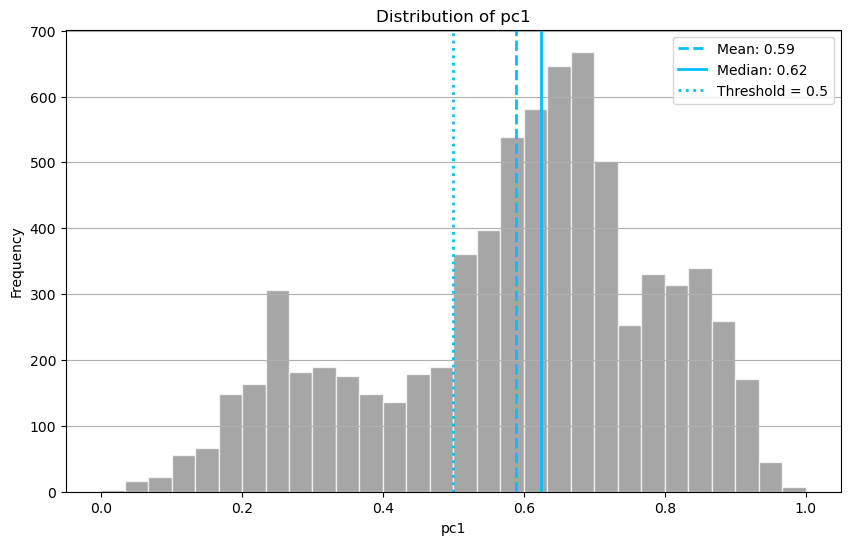

In [28]:
# Compute mean and median
mean_value = aggregated_data['pc1'].mean()
median_value = aggregated_data['pc1'].median()
threshold = 0.5  # Given threshold

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(aggregated_data['pc1'], color='grey', alpha=0.7, edgecolor='white', bins=30)  # Adjust bins if needed

# Add vertical lines for mean, median, and threshold
plt.axvline(mean_value, color='deepskyblue', linestyle='--', linewidth=2, label=f'Mean: {mean_value:.2f}')
plt.axvline(median_value, color='deepskyblue', linestyle='-', linewidth=2, label=f'Median: {median_value:.2f}')
plt.axvline(threshold, color='deepskyblue', linestyle=':', linewidth=2, label='Threshold = 0.5')

# Customize plot
plt.title('Distribution of pc1')
plt.xlabel('pc1')
plt.ylabel('Frequency')
plt.grid(axis='y')
plt.legend()  # Show legend for the lines

# Save and show the plot
plt.savefig('../03_plots/hist_pc1.png')
plt.show()

In [33]:
aggregated_data

,domain,virality,avalanches,messages,chats,year,pc1,domain_index
0,100giornidaleoni.it,0.946939,1.313333,1.433333,1.213333,2021.906667,0.259866,0
1,100milefreepress.net,0.707107,2.000000,2.000000,2.000000,2022.000000,0.599200,1
2,100percentfedup.com,0.911149,1.935955,3.427850,1.762025,2022.143768,0.219380,2
3,1011now.com,0.844692,2.215054,2.698925,1.924731,2021.580645,0.716641,3
4,10news.com,0.888128,2.921569,4.176471,2.792157,2021.749020,0.705943,4
...,...,...,...,...,...,...,...,...
7389,zmescience.com,0.838569,2.309278,2.855670,1.848797,2021.573883,0.891073,7389
7390,zombie.news,1.000000,1.000000,1.000000,1.000000,2023.000000,0.243898,7390
7391,zonazealots.com,0.707107,2.000000,4.000000,1.000000,2021.000000,0.648646,7391
7392,zuerst.de,0.985833,1.066148,1.217899,1.077821,2022.832685,0.675067,7392


## Train Test Split

In [68]:
# Train-test split based on nodes (domains)
unique_domains = aggregated_data['domain'].unique()
train_domains, test_domains = train_test_split(unique_domains, test_size=0.2, random_state=42)

# Split data into train and test sets
train_data = aggregated_data[aggregated_data['domain'].isin(train_domains)]
test_data = aggregated_data[aggregated_data['domain'].isin(test_domains)]

node_features = aggregated_data[['domain_id', 'domain', 'virality', 'avalanches', 'messages', 'chats', 'year', 'pc1']].copy()

node_features['domain_id'] = node_features['domain_id'].astype(int)
node_features['year'] = node_features['year'].astype(int)
#node_features['virality'] = node_features['virality'].round(2)

## Filter Chat URL matrix

In [36]:
# Mapping
unique_domains = train_data['domain'].dropna().unique()
url_to_domain = url_domains.set_index('url')['domain']
domain_to_index_map = train_data.set_index('domain')['domain_id']
#train_data['domain_index'] = article_embeddings['domain'].map(domain_to_index_map)
article_url_map = url_domains.set_index('index')['url']

In [40]:
unique_domains

array(['100milefreepress.net', '100percentfedup.com', '1011now.com', ...,
       'zombie.news', 'zonazealots.com', 'zuerst.de'], dtype=object)

In [42]:
train_domains_set = set(train_domains)

In [57]:
# Create edge list from filtered_chat_url_shares with domain indices
rows, cols = chat_url_shares.tocsr().nonzero()
edges = []

for row, col in tqdm(zip(rows, cols), total=len(rows), desc="Processing chat-url pairs"):
    url = article_url_map.get(col, None)  # Get URL safely
    if url is not None:
        domain = url_to_domain.get(url, None)  # Map URL to domain
        if isinstance(domain, pd.Series):
            domain = domain.iloc[0]
        if domain in train_domains_set:  # Only include training domains
            domain_index = domain_to_index_map.get(domain)  # Get index
            if domain_index is not None:
                edges.append((row, domain_index))  # Add valid edge

Processing chat-url pairs: 100%|██████████| 88524359/88524359 [07:20<00:00, 200895.41it/s]


In [58]:
train_edge_list = pd.DataFrame(edges, columns=['chat_id', 'domain_id'])

In [60]:
# Ensure proper integer type
train_edge_list['chat_id'] = train_edge_list['chat_id'].astype(int)
train_edge_list['domain_id'] = train_edge_list['domain_id'].astype(int)

# Print statistics for verification
print(f"Train Edge List Shape: {train_edge_list.shape}")
print(f"Max domain index: {train_edge_list['domain_id'].max()}")
print(f"Min domain index: {train_edge_list['domain_id'].min()}")

Train Edge List Shape: (21158435, 2)
Max domain index: 7392
Min domain index: 1


In [61]:
from scipy.sparse import coo_matrix

chat_domain_shares = coo_matrix(
    (np.ones(len(train_edge_list)), (train_edge_list['chat_id'], train_edge_list['domain_id']))
)

In [62]:
chat_domain_shares

<64977x7393 sparse matrix of type '<class 'numpy.float64'>'
	with 21158435 stored elements in COOrdinate format>

In [63]:
node_features

,domain_index,domain,virality,avalanches,messages,chats,year,pc1
0,0,100giornidaleoni.it,0.946939,1.313333,1.433333,1.213333,2021,0.259866
1,1,100milefreepress.net,0.707107,2.000000,2.000000,2.000000,2022,0.599200
2,2,100percentfedup.com,0.911149,1.935955,3.427850,1.762025,2022,0.219380
3,3,1011now.com,0.844692,2.215054,2.698925,1.924731,2021,0.716641
4,4,10news.com,0.888128,2.921569,4.176471,2.792157,2021,0.705943
...,...,...,...,...,...,...,...,...
7389,7389,zmescience.com,0.838569,2.309278,2.855670,1.848797,2021,0.891073
7390,7390,zombie.news,1.000000,1.000000,1.000000,1.000000,2023,0.243898
7391,7391,zonazealots.com,0.707107,2.000000,4.000000,1.000000,2021,0.648646
7392,7392,zuerst.de,0.985833,1.066148,1.217899,1.077821,2022,0.675067


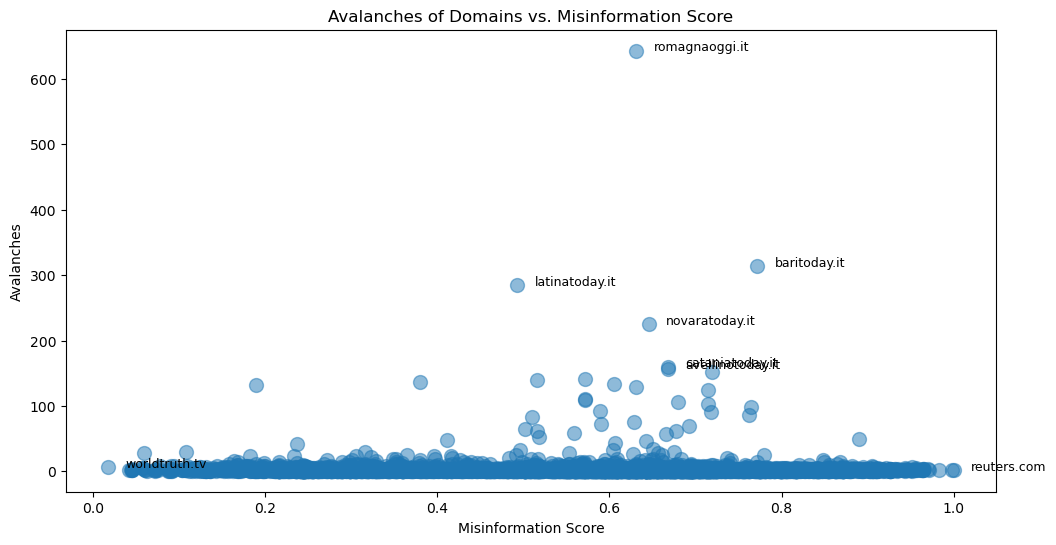

In [64]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data
# train_sample = train_data.sample(n=100, random_state=42)

# Define outlier thresholds for avalanches
pc1_threshold_high = train_data['pc1'].quantile(0.9999) 
pc1_threshold_low = train_data['pc1'].quantile(0.0001)   
avalanches_threshold_high = train_data['avalanches'].quantile(0.999)  
avalanches_threshold_low = train_data['avalanches'].quantile(0.001)  

# Scatter plot
plt.figure(figsize=(12, 6))
sc = plt.scatter(
    train_data['pc1'], 
    train_data['avalanches'], 
    alpha=0.5, 
    #c=train_sample['avalanches'], 
    #cmap='BuGn', 
    s=100
)

# Add color bar
#plt.colorbar(sc, label='Avalanches')

# Labeling
plt.xlabel('Misinformation Score')
plt.ylabel('Avalanches')
plt.title('Avalanches of Domains vs. Misinformation Score')

# Add labels for outliers
for pc1, avalanches, domain in zip(train_data['pc1'], train_data['avalanches'], train_data['domain']):
    if pc1 > pc1_threshold_high or pc1 < pc1_threshold_low or avalanches > avalanches_threshold_high or avalanches < avalanches_threshold_low:
        plt.text(pc1 + 0.02, avalanches, domain, fontsize=9)

# Save the figure
plt.savefig('../03_plots/sample_scatter_outliers_pc1_avalanches.png')
plt.show()


## Export

In [69]:
print(train_data.info())
print(test_data.info())
print(train_edge_list.info())

<class 'pandas.core.frame.DataFrame'>
Index: 5915 entries, 1 to 7392
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   domain      5915 non-null   object 
 1   virality    5915 non-null   float64
 2   avalanches  5915 non-null   float64
 3   messages    5915 non-null   float64
 4   chats       5915 non-null   float64
 5   year        5915 non-null   float64
 6   pc1         5915 non-null   float64
 7   domain_id   5915 non-null   int64  
dtypes: float64(6), int64(1), object(1)
memory usage: 415.9+ KB
None
<class 'pandas.core.frame.DataFrame'>
Index: 1479 entries, 0 to 7393
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   domain      1479 non-null   object 
 1   virality    1479 non-null   float64
 2   avalanches  1479 non-null   float64
 3   messages    1479 non-null   float64
 4   chats       1479 non-null   float64
 5   year        1479 non-null  

In [70]:
# Step 5: Save results
train_data.to_csv('../02_data/content_agnostic/train_data.csv', index=False)
test_data.to_csv('../02_data/content_agnostic/test_data.csv', index=False)
train_edge_list.to_csv('../02_data/content_agnostic/train_edge_list.csv', index=False)
node_features.to_csv('../02_data/content_agnostic/node_features.csv', index=False)